**Import all the required libraries**

In [ ]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

**Load dataset from google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import the train dataset and check the features**

In [ ]:
df_train_data_pathway = '/content/drive/My Drive/Project_Dataset2/drugsComTrain_raw.csv'
df_train_data = pd.read_csv(df_train_data_pathway)
df_train_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


**Import the test dataset and check the features**

In [ ]:
df_test_data_pathway = '/content/drive/My Drive/Project_Dataset/drugsComTest_raw.csv'
df_test_data = pd.read_csv(df_test_data_pathway)
df_test_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


**Load spacy model for preprocessing the dataset**

In [ ]:
nlp = spacy.load('en_core_web_sm')

**Combine the train and test datasets and check the shape**

In [ ]:
merge = [df_train_data,df_test_data]
df_review_data= pd.concat(merge,ignore_index=True)

df_review_data.shape

(215063, 7)

**Randomly select only 10,000 samples for analysis**

In [ ]:
df_review_data = df_review_data.sample(n=10000, random_state=42)
df_review_data.shape

(10000, 7)

**Check for null values and features with the highest number of null values**

In [ ]:
df_review_data.isnull().sum()

uniqueID        0
drugName        0
condition      54
review          0
rating          0
date            0
usefulCount     0
dtype: int64

**Drop the null values**

In [ ]:
df_review_data.dropna(inplace=True, axis=0)

**A function to preprocess the text reviews**

In [ ]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    doc = nlp(text.lower())
    text = text.replace("n't", " not")
    return ' '.join(token.lemma_ for token in doc if not token.is_stop and not token.is_punct)

**Applying the function on the review feature**

In [ ]:
df_review_data['cleaned_feedback'] = df_review_data['review'].apply(preprocess_text)

**Checking the preprocessed data using the head function**

In [ ]:
df_review_data.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount,cleaned_feedback
14311,57701,Acetaminophen / hydrocodone,Pain,"""I suffered a .45 caliber GSW to the head in 2...",9,26-Jun-15,10,suffer caliber gsw head multiple omfsent s...
72301,168695,Vilazodone,Major Depressive Disorde,"""I started on Viibryd after having a DNA test ...",1,27-Dec-15,1,start viibryd have dna test find medication ...
23041,1607,Eluxadoline,Irritable Bowel Syndrome,"""Not covered by insurance""",6,19-Dec-16,0,cover insurance
197721,17559,Ethinyl estradiol / etonogestrel,Birth Control,"""I previously did a review on Nuva Ring about ...",8,1-Nov-16,8,previously review nuva ring year ago opinion n...
133612,158793,Methylphenidate,ADHD,"""My son was prescribed the drug just before su...",6,3-Sep-09,17,son prescribe drug summer work great beginni...
152966,139328,Armodafinil,Narcolepsy,"""After being diagnosed at age 35, with narcole...",2,7-Jul-15,19,diagnose age narcolepsy rem sleep behavior d...
53745,161508,Diphenhydramine,Allergic Reactions,"""Drowsiness is a reoccurring problem for me. I...",7,19-Oct-15,3,drowsiness reoccurring problem difficulty focu...
90532,122141,Venlafaxine,Depression,"""I was told to take Effexor Rx at the age of 1...",8,3-Nov-09,25,tell effexor rx age respond horrible antidep...
5571,17896,Ethinyl estradiol / etonogestrel,Birth Control,"""Overall, it works great. I have used the Nuva...",9,19-Jul-13,13,overall work great nuvaring past month like ...
98666,14936,Ethinyl estradiol / norethindrone,Birth Control,"""This pill is effective in preventing pregnanc...",7,9-Aug-17,3,pill effective prevent pregnancy help acne not...


**A function to apply sentiment analysis using textblob**

In [ ]:
def analyze_sentiment(cleaned_feedback):
    blob = TextBlob(cleaned_feedback)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

df_review_data[['polarity', 'subjectivity_score']] = df_review_data['cleaned_feedback'].apply(lambda x: pd.Series(analyze_sentiment(x)))


**checked the analysed data**

In [ ]:
df_review_data.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount,cleaned_feedback,polarity,subjectivity_score
14311,57701,Acetaminophen / hydrocodone,Pain,"""I suffered a .45 caliber GSW to the head in 2...",9,26-Jun-15,10,suffer caliber gsw head multiple omfsent s...,0.187500,0.437500
72301,168695,Vilazodone,Major Depressive Disorde,"""I started on Viibryd after having a DNA test ...",1,27-Dec-15,1,start viibryd have dna test find medication ...,-0.379167,0.727083
23041,1607,Eluxadoline,Irritable Bowel Syndrome,"""Not covered by insurance""",6,19-Dec-16,0,cover insurance,0.000000,0.000000
197721,17559,Ethinyl estradiol / etonogestrel,Birth Control,"""I previously did a review on Nuva Ring about ...",8,1-Nov-16,8,previously review nuva ring year ago opinion n...,0.206994,0.526488
133612,158793,Methylphenidate,ADHD,"""My son was prescribed the drug just before su...",6,3-Sep-09,17,son prescribe drug summer work great beginni...,0.222222,0.488889
152966,139328,Armodafinil,Narcolepsy,"""After being diagnosed at age 35, with narcole...",2,7-Jul-15,19,diagnose age narcolepsy rem sleep behavior d...,-0.380000,0.708333
53745,161508,Diphenhydramine,Allergic Reactions,"""Drowsiness is a reoccurring problem for me. I...",7,19-Oct-15,3,drowsiness reoccurring problem difficulty focu...,-0.243750,0.450000
90532,122141,Venlafaxine,Depression,"""I was told to take Effexor Rx at the age of 1...",8,3-Nov-09,25,tell effexor rx age respond horrible antidep...,-0.250000,0.583333
5571,17896,Ethinyl estradiol / etonogestrel,Birth Control,"""Overall, it works great. I have used the Nuva...",9,19-Jul-13,13,overall work great nuvaring past month like ...,0.038889,0.538889
98666,14936,Ethinyl estradiol / norethindrone,Birth Control,"""This pill is effective in preventing pregnanc...",7,9-Aug-17,3,pill effective prevent pregnancy help acne not...,0.516667,0.800000


**A function to categorize the sentiments using the polarity/sentiment score**

In [ ]:
def classify_sentiment(polarity):
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df_review_data['sentiment'] = df_review_data['polarity'].apply(classify_sentiment)

**Checking the categorized dataset**

In [ ]:
df_review_data.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount,cleaned_feedback,polarity,subjectivity_score,sentiment
14311,57701,Acetaminophen / hydrocodone,Pain,"""I suffered a .45 caliber GSW to the head in 2...",9,26-Jun-15,10,suffer caliber gsw head multiple omfsent s...,0.187500,0.437500,Positive
72301,168695,Vilazodone,Major Depressive Disorde,"""I started on Viibryd after having a DNA test ...",1,27-Dec-15,1,start viibryd have dna test find medication ...,-0.379167,0.727083,Negative
23041,1607,Eluxadoline,Irritable Bowel Syndrome,"""Not covered by insurance""",6,19-Dec-16,0,cover insurance,0.000000,0.000000,Neutral
197721,17559,Ethinyl estradiol / etonogestrel,Birth Control,"""I previously did a review on Nuva Ring about ...",8,1-Nov-16,8,previously review nuva ring year ago opinion n...,0.206994,0.526488,Positive
133612,158793,Methylphenidate,ADHD,"""My son was prescribed the drug just before su...",6,3-Sep-09,17,son prescribe drug summer work great beginni...,0.222222,0.488889,Positive
152966,139328,Armodafinil,Narcolepsy,"""After being diagnosed at age 35, with narcole...",2,7-Jul-15,19,diagnose age narcolepsy rem sleep behavior d...,-0.380000,0.708333,Negative
53745,161508,Diphenhydramine,Allergic Reactions,"""Drowsiness is a reoccurring problem for me. I...",7,19-Oct-15,3,drowsiness reoccurring problem difficulty focu...,-0.243750,0.450000,Negative
90532,122141,Venlafaxine,Depression,"""I was told to take Effexor Rx at the age of 1...",8,3-Nov-09,25,tell effexor rx age respond horrible antidep...,-0.250000,0.583333,Negative
5571,17896,Ethinyl estradiol / etonogestrel,Birth Control,"""Overall, it works great. I have used the Nuva...",9,19-Jul-13,13,overall work great nuvaring past month like ...,0.038889,0.538889,Neutral
98666,14936,Ethinyl estradiol / norethindrone,Birth Control,"""This pill is effective in preventing pregnanc...",7,9-Aug-17,3,pill effective prevent pregnancy help acne not...,0.516667,0.800000,Positive


**EXPLORATORY AND VISUALIZATION OF THE RESULT OF THE PERFORMED SENTIMENT ANALYSIS ON THE DATASET USING TEXTBLOB**

**Plot the distribution of sentiment scores**

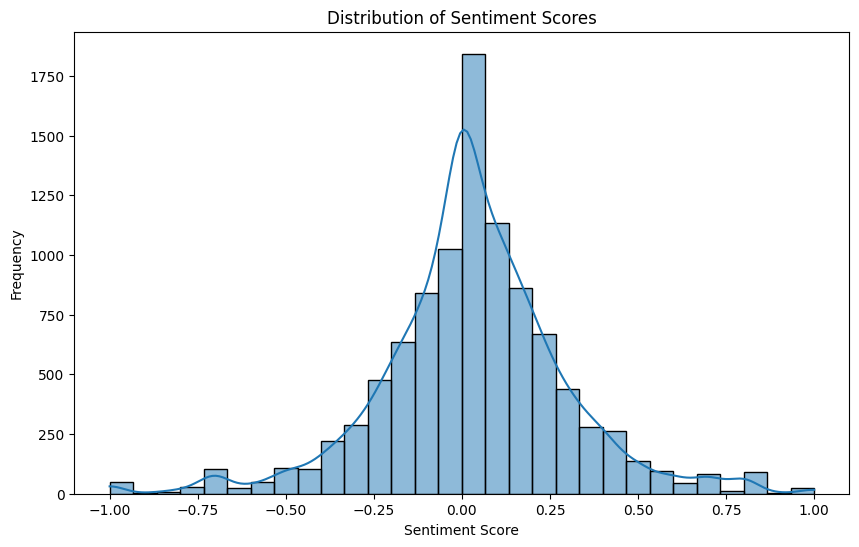

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_review_data['polarity'], bins=30, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

**Plot the distribution of sentiment categories**

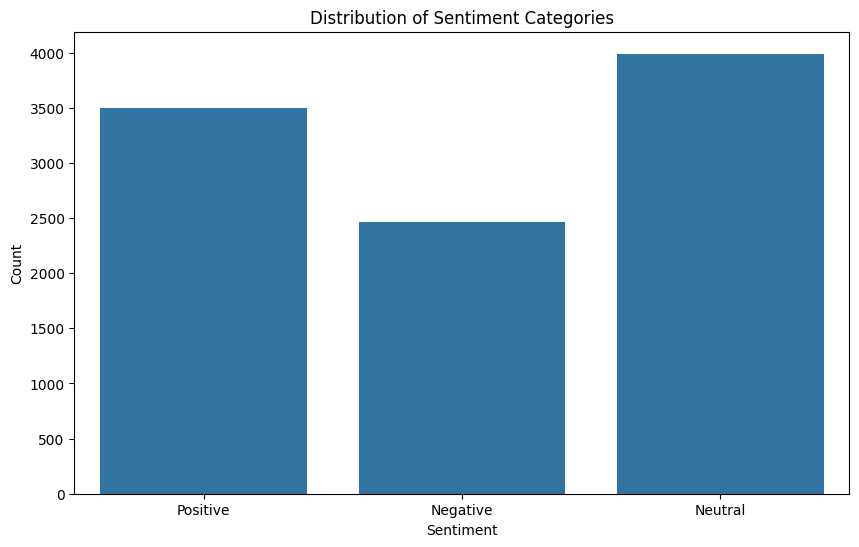

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_review_data, x='sentiment')
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

**Correlating between specific drugs and sentiment**

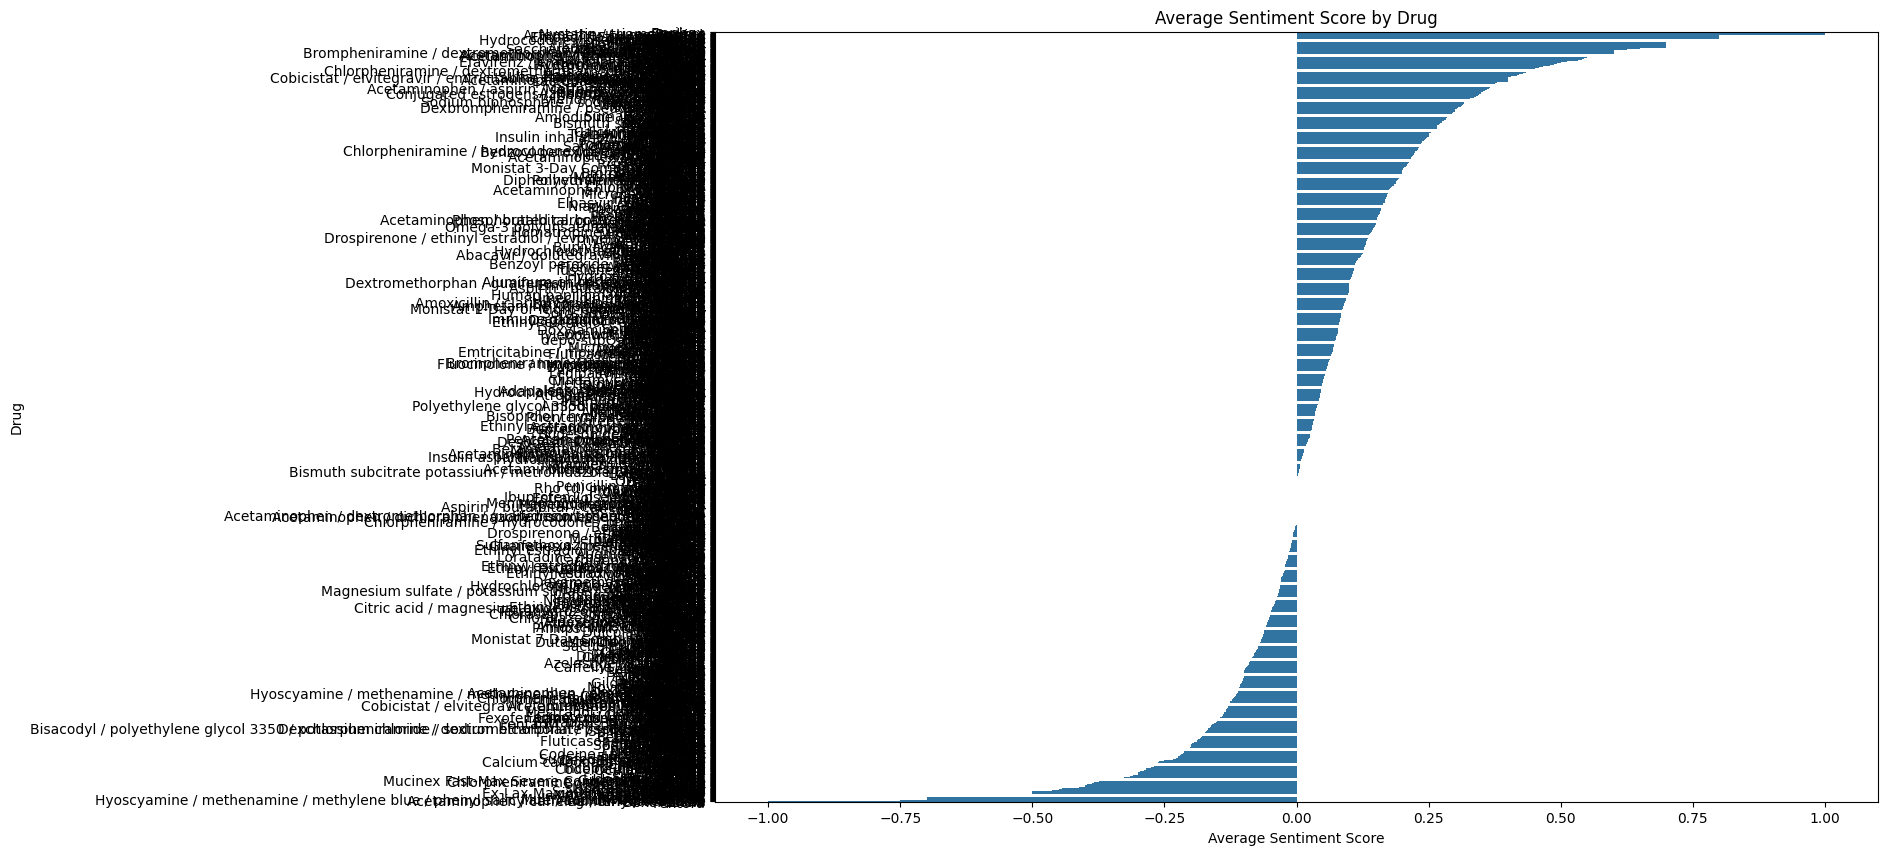

In [ ]:
drug_sentiment = df_review_data.groupby('drugName')['polarity'].mean().reset_index()
drug_sentiment = drug_sentiment.sort_values(by='polarity', ascending=False)

plt.figure(figsize=(15, 10))
sns.barplot(data=drug_sentiment, x='polarity', y='drugName')
plt.title('Average Sentiment Score by Drug')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Drug')
plt.show()

**Generating Positive and Negative feedback Word Clouds and plots**

In [ ]:
positive_feedback = ' '.join(df_review_data[df_review_data['sentiment'] == 'Positive']['cleaned_feedback'])
negative_feedback = ' '.join(df_review_data[df_review_data['sentiment'] == 'Negative']['cleaned_feedback'])

positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_feedback)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_feedback)

**Plot the Positive word clouds**

(-0.5, 799.5, 399.5, -0.5)

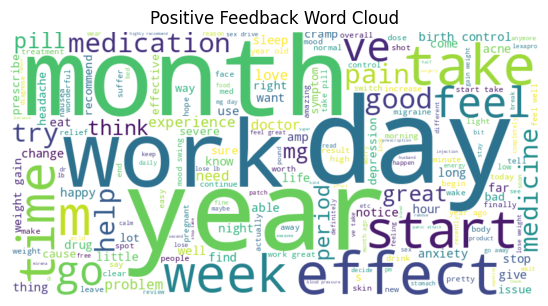

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Feedback Word Cloud')
plt.axis('off')

**Plot the Negative word clouds**

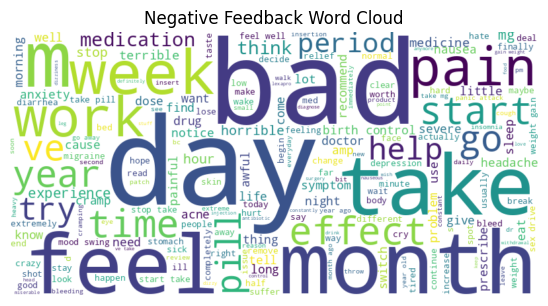

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Feedback Word Cloud')
plt.axis('off')

plt.show()

**A function to analyze common themes in feedback**

In [ ]:
def get_common_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    wordsBag = vec.transform(corpus)
    wordsSum = wordsBag.sum(axis=0)
    wordsFreq = [(word, wordsSum[0, idx]) for word, idx in vec.vocabulary_.items()]
    wordsFreq = sorted(wordsFreq, key = lambda x: x[1], reverse=True)
    return wordsFreq[:n]

**Applying the get function on the sentiment and the pre-processed review**

In [ ]:
positive_common_words = get_common_words(df_review_data[df_review_data['sentiment'] == 'Positive']['cleaned_feedback'])
negative_common_words = get_common_words(df_review_data[df_review_data['sentiment'] == 'Negative']['cleaned_feedback'])

**Printing the top 10 positive and negative feedbackts**

In [ ]:
print("Top 10 words in positive feedback:")
print(positive_common_words)

print("\nTop 10 words in negative feedback:")
print(negative_common_words)

Top 10 words in positive feedback:
[('day', 1770), ('year', 1532), ('work', 1476), ('month', 1421), ('feel', 1287), ('effect', 1213), ('good', 1117), ('week', 1080), ('start', 1075), ('ve', 1010)]

Top 10 words in negative feedback:
[('day', 1646), ('bad', 1405), ('feel', 1194), ('month', 1102), ('week', 929), ('start', 902), ('pain', 888), ('work', 830), ('year', 816), ('effect', 795)]


**Converting the rating feature to a binary feature (0s and 1s)**

In [ ]:
df_review_data['sentiments'] = df_review_data["rating"].apply(lambda x: 1 if x >= 5 else 0)

**CHECKING FOR UNBALANCED CLASSES**

**Functions to calculate, visualize and print the distribution of classes**

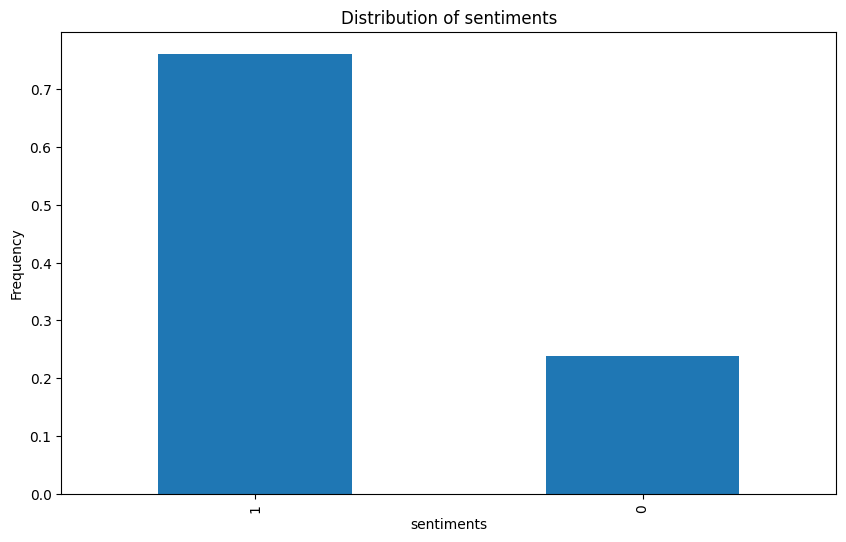

sentiments
1    0.76111
0    0.23889
Name: proportion, dtype: float64


In [ ]:
def calculate_distribution(df_review_data, sentiments):
    return df_review_data[sentiments].value_counts(normalize=True)

def visualize_distribution(distribution, sentiments):
    plt.figure(figsize=(10, 6))
    distribution.plot(kind='bar')
    plt.title(f'Distribution of {sentiments}')
    plt.xlabel(sentiments)
    plt.ylabel('Frequency')
    plt.show()

def main():

    distribution = calculate_distribution(df_review_data, 'sentiments')
    visualize_distribution(distribution, 'sentiments')
    print(distribution)

if __name__ == "__main__":
    main()

**To print the class distribution**

In [ ]:
class_distribution = df_review_data['sentiments'].value_counts()
print("Class distribution using value_counts:")
print(class_distribution)

Class distribution using value_counts:
sentiments
1    7570
0    2376
Name: count, dtype: int64


**To check class distribution using Counter**

In [ ]:
class_distribution_counter = Counter(df_review_data['sentiments'])
print("\nClass distribution using Counter:")
print(class_distribution_counter)


Class distribution using Counter:
Counter({1: 7570, 0: 2376})


**To visualize class distribution using matplotlib**

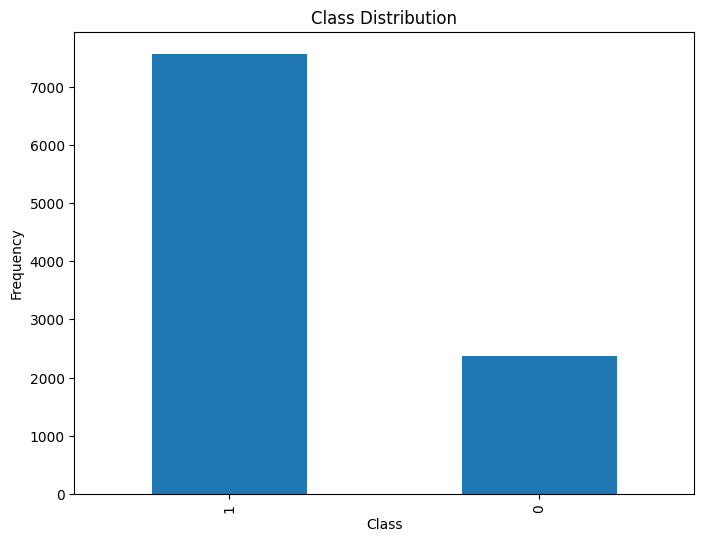

In [ ]:
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

**To visualize class distribution using seaborn**

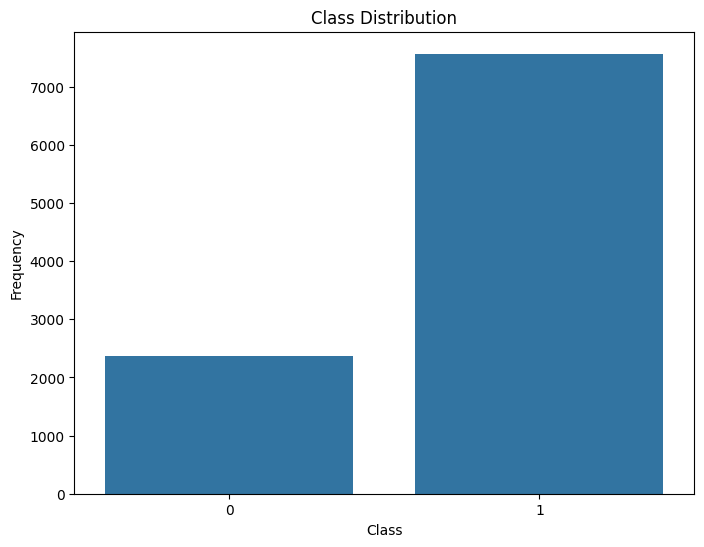

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiments', data=df_review_data)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

**To save the sentiments column with a variable**

In [ ]:
sentiments = df_review_data['sentiments']

**To perform feature engineering using tfidfvectorizer**

In [ ]:
vectorizer = TfidfVectorizer()
df_review = vectorizer.fit_transform(df_review_data['cleaned_feedback'])
df_review.shape

(9946, 15128)

**To split the dataset into train and test sets**

In [ ]:
X, X_test, y, y_test = train_test_split(df_review, sentiments, test_size=0.2, random_state=42)

**To balance the unbalanced classes**

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X, y)

# to check the distribution of classes after applying SMOTE
print(f"Original class distribution: {Counter(y)}")
print(f"Resampled class distribution: {Counter(y_train)}")

Original class distribution: Counter({1: 6047, 0: 1909})
Resampled class distribution: Counter({1: 6047, 0: 6047})


**IMPLEMENTATION OF THE MACHINE LEARNING TRAINING MODEL FROM SCRATCH**

**Building the decision tree classifier**

In [ ]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        y = np.array(y).flatten()
        if (self.max_depth is not None and depth >= self.max_depth) or n_samples < self.min_samples_split or len(np.unique(y)) == 1:
            return self._leaf(y)
        feat_idx, thresh = self._best_split(X, y, n_features)
        if feat_idx is None:
            return self._leaf(y)
        left_idxs, right_idxs = self._split(X[:, feat_idx], thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(feat_idx, thresh, left, right)

    def _best_split(self, X, y, n_features):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in range(n_features):
            X_column = X[:, feat_idx].toarray().flatten()  # Convert sparse to dense
            thresholds = np.unique(X_column)
            for thresh in thresholds:
                gain = self._information_gain(y, X_column, thresh)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = thresh
        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_left, n_right = len(left_idxs), len(right_idxs)
        e_left, e_right = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_left / n) * e_left + (n_right / n) * e_right
        return parent_entropy - child_entropy

    def _split(self, X_column, split_thresh):
        # Convert sparse matrix column to dense array
        X_column = X_column.toarray().flatten() if hasattr(X_column, "toarray") else X_column
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _leaf(self, y):
        return Leaf(np.bincount(y).argmax())

    def predict(self, X):
            X_dense = X.toarray() if hasattr(X, "toarray") else X
            return np.array([self._traverse_tree(x, self.tree) for x in X_dense])

    def _traverse_tree(self, x, node):
        if isinstance(node, Leaf):
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)



**Random Forest Classifier class**

In [ ]:
class RandomForestClassifier:
    def __init__(self, n_trees=20, max_depth=None, min_samples_split=2):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_trees):
            tree = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.squeeze(np.apply_along_axis(lambda x: np.bincount(x, minlength=2).argmax(), axis=0, arr=tree_preds))

class Node:
    def __init__(self, feature, threshold, left, right):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right

class Leaf:
    def __init__(self, value):
        self.value = value

**Creating an object instance of the class RandomForestClassifier() and training the dataset**

In [ ]:
RFC = RandomForestClassifier(n_trees=10, max_depth=5, min_samples_split=2)
RFC.fit(X_train, y_train)

**Making predictions using the test data**

In [ ]:
predictions = RFC.predict(X_test)
print("Predictions:", predictions)

Predictions: [1 1 1 ... 1 1 1]


**To evaluate using the accuracy, precision, recall and f1-score metrics**

In [ ]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.70
Precision: 0.81
Recall: 0.81
F1 Score: 0.81


**To evaluate using the accuracy, precision, recall and f1-score metrics with the macro Average**

In [ ]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.70
Precision: 0.59
Recall: 0.59
F1 Score: 0.59


**To calculate and visualize the Confusion Matrix**

Confusion Matrix:
[[ 173  294]
 [ 294 1229]]


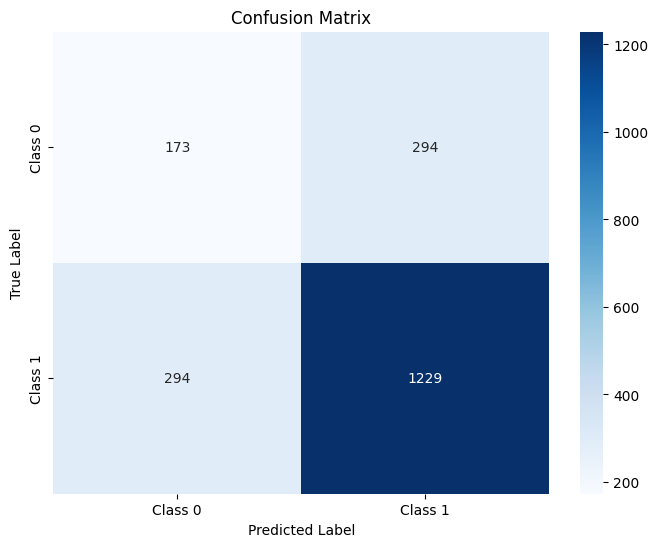

In [ ]:
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**PERFORM HYPERPARAMETER TUNNING**

**Define and set up the hyperparameter grid**

In [ ]:
param_grid = {
    'n_trees': [10, 15, 20, 25, 30],
    'max_depth': [None, 8, 10, 15],
    'min_samples_split': [2, 5, 8]
}

**Set Up the Custom RandomForestClassifier**

In [ ]:
class RandomForestClassifier:
    def __init__(self, n_trees=20, max_depth=None, min_samples_split=2):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.squeeze(np.apply_along_axis(lambda x: np.bincount(x, minlength=2).argmax(), axis=0, arr=tree_preds))

    def get_params(self, deep=True):
        return {'n_trees': self.n_trees, 'max_depth': self.max_depth, 'min_samples_split': self.min_samples_split}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

**Initialize the RandomForestClassifier, set up gridsearchCV and train the data**

In [ ]:
RFC = RandomForestClassifier()
grid_search = GridSearchCV(estimator=RFC, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Best Model Accuracy: {grid_search.best_score_:.4f}")



Fitting 5 folds for each of 60 candidates, totalling 300 fits


**To print the best parameter and the best model**

In [ ]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Best Model Accuracy: {grid_search.best_score_:.4f}")

**Evaluate and predict on the test set with the best model**

In [ ]:
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(classification_report(y_test, y_pred))

**To evaluate using the accuracy, precision, recall and f1-score metrics with the macro average**

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

**To calculate and visualize the Confusion Matrix**

In [ ]:
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**To save the model using Pickle**

In [ ]:
import pickle

model_path = '/content/drive/MyDrive/Project_Dataset2/model2.pkl'

with open(model_path, 'wb') as file:
    pickle.dump(best_model, file)

vectorizer_path = '/content/drive/MyDrive/Project_Dataset2/vectorizer2.pkl'

with open(vectorizer_path, 'wb') as file:
    pickle.dump(vectorizer, file)

print(f"Model saved to {model_path}")
print(f"Vectorizer saved to {vectorizer_path}")
